In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

# 1) Пытаемся найти файл и из корня проекта, и из папки notebooks
possible_paths = [
    Path("data/Real_estate_Tel_Aviv_20_years.csv"),
    Path("../data/Real_estate_Tel_Aviv_20_years.csv"),
]

data_path = next((p for p in possible_paths if p.exists()), None)

if data_path is None:
    raise FileNotFoundError(
        "Не найден файл Real_estate_Tel_Aviv_20_years.csv.\n"
        "Проверь, что он лежит в папке data/ в корне проекта."
    )

df = pd.read_csv(data_path)
print("Loaded:", data_path)
print("Raw shape:", df.shape)

# 2) Убираем мусорные Unnamed-колонки
df = df.loc[:, ~df.columns.str.startswith("Unnamed")].copy()
print("Clean shape:", df.shape)

# 3) Приводим дату сделки к datetime (в датасете формат похож на day/month/year)
if "transactionDate" in df.columns:
    df["transactionDate"] = pd.to_datetime(df["transactionDate"], errors="coerce", dayfirst=True)

df.head()


Loaded: ../data/Real_estate_Tel_Aviv_20_years.csv
Raw shape: (5901, 40)
Clean shape: (5901, 21)


,subLot,lot,bloc,transactionDate,street,houseNumber,apartmentNumber,price,grossArea,netArea,...,ppsm,ppr,floor,floors,apartmentsInBuilding,parking,storage,roof,yard,constructionYear
0,5,814,6628,2020-12-01,1,9,5.0,4636021,118.0,118,...,39288.0,1159005.0,1.0,20.0,66.0,0.0,0.0,0.0,0.0,2019
1,0,814,6628,2020-10-29,1,5,5.0,4559044,118.0,118,...,38636.0,1139761.0,1.0,17.0,66.0,0.0,0.0,0.0,0.0,2019
2,48,640,6628,2020-06-15,1,48,48.0,7350000,196.0,196,...,37500.0,1470000.0,12.0,13.0,48.0,4.0,0.0,63.0,0.0,1996
3,0,14,6107,2018-04-10,2,1,0.0,3355000,145.0,145,...,23138.0,838750.0,29.0,42.0,177.0,0.0,0.0,0.0,0.0,2018
4,106,14,6107,2018-04-04,2,2,0.0,2720360,144.0,144,...,18891.0,544072.0,6.0,42.0,177.0,0.0,0.0,0.0,0.0,2018


In [4]:
# Ячейка 2: Типы данных + чистим netArea

# 1) Смотрим типы ключевых колонок (быстро)
key_cols = [
    "price", "grossArea", "netArea", "rooms",
    "floor", "floors", "apartmentsInBuilding",
    "parking", "storage", "roof", "yard",
    "constructionYear"
]

existing_key_cols = [c for c in key_cols if c in df.columns]
print("Key columns found:", existing_key_cols)

print("\nDtypes BEFORE:")
print(df[existing_key_cols].dtypes)

# 2) Чистим netArea: убираем запятые и приводим к числу
if "netArea" in df.columns:
    df["netArea"] = pd.to_numeric(
        df["netArea"].astype(str).str.replace(",", "", regex=False),
        errors="coerce"
    )

# 3) На всякий случай приводим grossArea тоже к числу
if "grossArea" in df.columns:
    df["grossArea"] = pd.to_numeric(df["grossArea"], errors="coerce")

# 4) Проверяем типы и пропуски после
print("\nDtypes AFTER:")
print(df[existing_key_cols].dtypes)

print("\nMissing values in key cols:")
print(df[existing_key_cols].isna().sum().sort_values(ascending=False))

df[existing_key_cols].head()


Key columns found: ['price', 'grossArea', 'netArea', 'rooms', 'floor', 'floors', 'apartmentsInBuilding', 'parking', 'storage', 'roof', 'yard', 'constructionYear']

Dtypes BEFORE:
price                     int64
grossArea               float64
netArea                  object
rooms                   float64
floor                   float64
floors                  float64
apartmentsInBuilding    float64
parking                 float64
storage                 float64
roof                    float64
yard                    float64
constructionYear          int64
dtype: object

Dtypes AFTER:
price                     int64
grossArea               float64
netArea                 float64
rooms                   float64
floor                   float64
floors                  float64
apartmentsInBuilding    float64
parking                 float64
storage                 float64
roof                    float64
yard                    float64
constructionYear          int64
dtype: object

Missing v

,price,grossArea,netArea,rooms,floor,floors,apartmentsInBuilding,parking,storage,roof,yard,constructionYear
0,4636021,118.0,118.0,4.0,1.0,20.0,66.0,0.0,0.0,0.0,0.0,2019
1,4559044,118.0,118.0,4.0,1.0,17.0,66.0,0.0,0.0,0.0,0.0,2019
2,7350000,196.0,196.0,5.0,12.0,13.0,48.0,4.0,0.0,63.0,0.0,1996
3,3355000,145.0,145.0,4.0,29.0,42.0,177.0,0.0,0.0,0.0,0.0,2018
4,2720360,144.0,144.0,5.0,6.0,42.0,177.0,0.0,0.0,0.0,0.0,2018


In [5]:
# Ячейка 3: Feature engineering + train/test (Tel Aviv, log(price))

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

assert "price" in df.columns, "В df нет колонки price. Проверь загрузку данных."

df = df.copy()

# 1) Убираем нулевые/отрицательные цены
df = df[df["price"] > 0].copy()
print("После фильтра price>0:", df.shape)

# 2) Парсим дату сделки
if "transactionDate" in df.columns:
    # dayfirst=True важен, потому что даты выглядят как 01/12/2020
    df["transactionDate"] = pd.to_datetime(
        df["transactionDate"],
        errors="coerce",
        dayfirst=True
    )
    df["tx_year"] = df["transactionDate"].dt.year
    df["tx_month"] = df["transactionDate"].dt.month
    df["tx_quarter"] = df["transactionDate"].dt.quarter
else:
    df["tx_year"] = np.nan
    df["tx_month"] = np.nan
    df["tx_quarter"] = np.nan

# 3) Возраст здания на момент сделки
if "constructionYear" in df.columns:
    df["building_age_at_tx"] = df["tx_year"] - df["constructionYear"]
    # если вдруг получилось отрицательное — считаем это ошибкой данных
    df.loc[df["building_age_at_tx"] < 0, "building_age_at_tx"] = np.nan
else:
    df["building_age_at_tx"] = np.nan

# 4) Относительный этаж (этаж / всего этажей)
if "floor" in df.columns and "floors" in df.columns:
    df["floor_ratio"] = df["floor"] / df["floors"].replace(0, np.nan)
else:
    df["floor_ratio"] = np.nan

# 5) Список признаков
# ВАЖНО: мы не используем ppsm / ppr, потому что они обычно производные от price
# и могут давать утечку таргета.
base_features = [
    "netArea", "grossArea", "rooms", "floor", "floors",
    "apartmentsInBuilding", "parking", "storage", "roof", "yard",
    "constructionYear",
    "tx_year", "tx_month", "tx_quarter",
    "building_age_at_tx", "floor_ratio",
]

features = [c for c in base_features if c in df.columns]
print("Используемые признаки:", features)

X = df[features].copy()
y_raw = df["price"].astype(float).copy()
y_log = np.log1p(y_raw)

# 6) Train/test split сразу для log-цели и сырого price
X_train, X_test, y_train, y_test, y_train_raw, y_test_raw = train_test_split(
    X, y_log, y_raw,
    test_size=0.2,
    random_state=42
)

print("Форма X_train:", X_train.shape)
print("Форма X_test :", X_test.shape)

print("\nFeature sanity:")
print("Any NaN in X_train:", X_train.isna().any().any())
print("Any inf in X_train numeric:", np.isinf(X_train.select_dtypes(include=[np.number])).any().any())

# Для удобства визуально
X_train.head()


После фильтра price>0: (5896, 21)
Используемые признаки: ['netArea', 'grossArea', 'rooms', 'floor', 'floors', 'apartmentsInBuilding', 'parking', 'storage', 'roof', 'yard', 'constructionYear', 'tx_year', 'tx_month', 'tx_quarter', 'building_age_at_tx', 'floor_ratio']
Форма X_train: (4716, 16)
Форма X_test : (1180, 16)

Feature sanity:
Any NaN in X_train: True
Any inf in X_train numeric: False


,netArea,grossArea,rooms,floor,floors,apartmentsInBuilding,parking,storage,roof,yard,constructionYear,tx_year,tx_month,tx_quarter,building_age_at_tx,floor_ratio
4762,94.0,NaN,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,2015,2015,4,2,0.0,1.00
858,78.0,78.0,2.0,3.0,4.0,16.0,0.0,0.0,0.0,0.0,1950,2019,12,4,69.0,0.75
3628,39.0,0.0,1.5,4.0,4.0,21.0,0.0,0.0,0.0,0.0,1960,2006,11,4,46.0,1.00
4688,56.0,56.0,3.0,1.0,4.0,24.0,0.0,0.0,0.0,0.0,1960,2019,10,4,59.0,0.25
1547,35.0,35.0,2.0,4.0,4.0,15.0,0.0,0.0,0.0,0.0,1960,2017,12,4,57.0,1.00


In [6]:
# Ячейка 4: Gradient Boosting baseline (с log(price)) + сравнение с Linear

import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- маленькая функция для аккуратной оценки ---
def evaluate_raw_price(name, y_true_raw, y_pred_log):
    # возвращаемся из log1p
    y_pred_raw = np.expm1(y_pred_log)

    # защита от отрицательных прогнозов
    y_pred_raw = np.clip(y_pred_raw, 0, None)

    mae = mean_absolute_error(y_true_raw, y_pred_raw)
    mse = mean_squared_error(y_true_raw, y_pred_raw)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_raw, y_pred_raw)

    print(f"\n{name}")
    print(f"MAE : {mae:,.0f} ₪")
    print(f"RMSE: {rmse:,.0f} ₪")
    print(f"R²  : {r2:.3f}")

    return mae, rmse, r2


# --- 1) Linear baseline (на log(price)) ---
lin_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
y_pred_log_lin = lin_pipe.predict(X_test)

mae_lin, rmse_lin, r2_lin = evaluate_raw_price(
    "LinearRegression (trained on log(price))",
    y_test_raw,
    y_pred_log_lin
)


# --- 2) Gradient Boosting baseline (на log(price)) ---
gbr_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GradientBoostingRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9
    ))
])

gbr_pipe.fit(X_train, y_train)
y_pred_log_gbr = gbr_pipe.predict(X_test)

mae_gbr, rmse_gbr, r2_gbr = evaluate_raw_price(
    "GradientBoostingRegressor (trained on log(price))",
    y_test_raw,
    y_pred_log_gbr
)


# --- 3) Сравнение ---
print("\n=== Delta (GBR - Linear) ===")
print(f"Δ MAE : {mae_gbr - mae_lin:,.0f} ₪")
print(f"Δ RMSE: {rmse_gbr - rmse_lin:,.0f} ₪")
print(f"Δ R²  : {r2_gbr - r2_lin:.3f}")



LinearRegression (trained on log(price))
MAE : 858,171 ₪
RMSE: 1,778,791 ₪
R²  : 0.387

GradientBoostingRegressor (trained on log(price))
MAE : 723,200 ₪
RMSE: 1,445,499 ₪
R²  : 0.595

=== Delta (GBR - Linear) ===
Δ MAE : -134,971 ₪
Δ RMSE: -333,291 ₪
Δ R²  : 0.208


In [8]:
# Ячейка 5: Быстрое сравнение моделей (log(price))

import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def evaluate_raw_price(name, y_true_raw, y_pred_log):
    y_pred_raw = np.expm1(y_pred_log)
    y_pred_raw = np.clip(y_pred_raw, 0, None)

    mae = mean_absolute_error(y_true_raw, y_pred_raw)
    rmse = np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))
    r2 = r2_score(y_true_raw, y_pred_raw)

    print(f"\n{name}")
    print(f"MAE : {mae:,.0f} ₪")
    print(f"RMSE: {rmse:,.0f} ₪")
    print(f"R²  : {r2:.3f}")
    return mae, rmse, r2


models = {
    "Linear": LinearRegression(),
    "GBR": GradientBoostingRegressor(
        random_state=42,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9
    ),
    "RandomForest": RandomForestRegressor(
        random_state=42,
        n_estimators=400,
        max_depth=None,
        min_samples_split=4,
        n_jobs=-1
    ),
    "ExtraTrees": ExtraTreesRegressor(
        random_state=42,
        n_estimators=500,
        max_depth=None,
        min_samples_split=4,
        n_jobs=-1
    ),
    "HistGBR": HistGradientBoostingRegressor(
        random_state=42,
        max_depth=6,
        learning_rate=0.05,
        max_iter=400
    )
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred_log = pipe.predict(X_test)

    mae, rmse, r2 = evaluate_raw_price(
        f"{name} (trained on log(price))",
        y_test_raw,
        y_pred_log
    )
    results[name] = (mae, rmse, r2)

print("\n=== Summary ===")
for k, (mae, rmse, r2) in sorted(results.items(), key=lambda x: -x[1][2]):
    print(f"{k:12s} | MAE {mae:,.0f} | RMSE {rmse:,.0f} | R² {r2:.3f}")



Linear (trained on log(price))
MAE : 858,171 ₪
RMSE: 1,778,791 ₪
R²  : 0.387

GBR (trained on log(price))
MAE : 718,143 ₪
RMSE: 1,433,070 ₪
R²  : 0.602

RandomForest (trained on log(price))
MAE : 673,636 ₪
RMSE: 1,434,999 ₪
R²  : 0.601

ExtraTrees (trained on log(price))
MAE : 659,631 ₪
RMSE: 1,445,707 ₪
R²  : 0.595

HistGBR (trained on log(price))
MAE : 729,013 ₪
RMSE: 1,485,657 ₪
R²  : 0.572

=== Summary ===
GBR          | MAE 718,143 | RMSE 1,433,070 | R² 0.602
RandomForest | MAE 673,636 | RMSE 1,434,999 | R² 0.601
ExtraTrees   | MAE 659,631 | RMSE 1,445,707 | R² 0.595
HistGBR      | MAE 729,013 | RMSE 1,485,657 | R² 0.572
Linear       | MAE 858,171 | RMSE 1,778,791 | R² 0.387


In [9]:
# Ячейка 6: Выбор победителя

# results: dict -> {"ModelName": (mae, rmse, r2)}

best_by_r2 = max(results.items(), key=lambda x: x[1][2])[0]
best_by_mae = min(results.items(), key=lambda x: x[1][0])[0]

print("Best by R2 :", best_by_r2)
print("Best by MAE:", best_by_mae)

# Рекомендация для деплоя:
BEST_MODEL_NAME = best_by_r2  # скорее всего "GBR"
print("✅ Selected for v2:", BEST_MODEL_NAME)


Best by R2 : GBR
Best by MAE: ExtraTrees
✅ Selected for v2: GBR


In [14]:
# Ячейка 7: Финальный X/y для обучения на всех данных (robust)

import numpy as np

# 1) Берём базовый df
if "df_model" not in globals():
    if "df" in globals():
        df_model = df.copy()
    else:
        raise NameError("Не найден df. Сначала запусти ячейки загрузки/подготовки данных.")

# 2) Фильтр price > 0
if "price" not in df_model.columns:
    raise KeyError("В df нет колонки 'price'.")

df_model = df_model[df_model["price"] > 0].copy()

# 3) Список признаков
if "feature_cols" not in globals():
    feature_cols = [
        "netArea", "grossArea", "rooms", "floor", "floors",
        "apartmentsInBuilding", "parking", "storage", "roof", "yard",
        "constructionYear", "tx_year", "tx_month", "tx_quarter",
        "building_age_at_tx", "floor_ratio"
    ]

# оставим только те, что реально есть в df_model
feature_cols = [c for c in feature_cols if c in df_model.columns]

# 4) X/y
X = df_model[feature_cols].copy()
y = np.log1p(df_model["price"].values)

print("df_model shape:", df_model.shape)
print("features used:", feature_cols)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Any NaN in X:", X.isna().any().any())


df_model shape: (5896, 26)
features used: ['netArea', 'grossArea', 'rooms', 'floor', 'floors', 'apartmentsInBuilding', 'parking', 'storage', 'roof', 'yard', 'constructionYear', 'tx_year', 'tx_month', 'tx_quarter', 'building_age_at_tx', 'floor_ratio']
X shape: (5896, 16)
y shape: (5896,)
Any NaN in X: True


In [15]:
# Ячейка 8: Где пропуски в X

nan_counts = X.isna().sum().sort_values(ascending=False)
nan_counts = nan_counts[nan_counts > 0]

print("NaN counts by feature:")
print(nan_counts)

print("\nNaN ratio by feature:")
print((nan_counts / len(X)).round(3))


NaN counts by feature:
storage                 2574
yard                    2541
roof                    2514
parking                 2352
apartmentsInBuilding    1585
grossArea               1243
netArea                  603
building_age_at_tx       582
floor_ratio              475
floors                   321
rooms                      6
floor                      1
dtype: int64

NaN ratio by feature:
storage                 0.437
yard                    0.431
roof                    0.426
parking                 0.399
apartmentsInBuilding    0.269
grossArea               0.211
netArea                 0.102
building_age_at_tx      0.099
floor_ratio             0.081
floors                  0.054
rooms                   0.001
floor                   0.000
dtype: float64


In [16]:
# Ячейка 9: Baseline с импутацией

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)

pred_log = lin_pipe.predict(X_test)

# возвращаемся из log
y_pred = np.expm1(pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("Linear baseline (log(price) + impute)")
print(f"MAE : {mae:,.0f} ₪")
print(f"RMSE: {rmse:,.0f} ₪")
print(f"R²  : {r2:.3f}")


Linear baseline (log(price) + impute)
MAE : 858,171 ₪
RMSE: 1,778,791 ₪
R²  : 0.387


In [17]:
# Ячейка 10: Strong baseline — RandomForest (log(price))

from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1
    ))
])

rf_pipe.fit(X_train, y_train)

pred_log = rf_pipe.predict(X_test)

y_pred = np.expm1(pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("RandomForest (log(price) + impute)")
print(f"MAE : {mae:,.0f} ₪")
print(f"RMSE: {rmse:,.0f} ₪")
print(f"R²  : {r2:.3f}")


RandomForest (log(price) + impute)
MAE : 668,393 ₪
RMSE: 1,422,071 ₪
R²  : 0.608


In [18]:
# Ячейка 11: Train final model on full data + save

import joblib
import json
from pathlib import Path

final_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    ))
])

final_model.fit(X, y)

Path("models").mkdir(exist_ok=True)

joblib.dump(final_model, "models/tel_aviv_real_estate_model_v2.pkl")

with open("models/tel_aviv_feature_cols_v2.json", "w") as f:
    json.dump(feature_cols, f, ensure_ascii=False, indent=2)

print("Saved:")
print(" - models/tel_aviv_real_estate_model_v2.pkl")
print(" - models/tel_aviv_feature_cols_v2.json")


Saved:
 - models/tel_aviv_real_estate_model_v2.pkl
 - models/tel_aviv_feature_cols_v2.json


In [25]:
# Cell 1: подготовка X / y с log(price)

import numpy as np
from sklearn.model_selection import train_test_split

# Предполагаем, что df_model уже есть и в нём есть колонка 'price'
# и список признаков feature_cols, которые мы использовали для v2.

X = df_model[feature_cols].copy()
y_price = df_model["price"].values  # оригинальная цена в шекелях
y_log = np.log1p(y_price)          # log1p(price) для обучения

X_train, X_test, y_train_log, y_test_log, y_train_price, y_test_price = train_test_split(
    X,
    y_log,
    y_price,
    test_size=0.2,
    random_state=42,
)
print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (4716, 16) X_test: (1180, 16)


In [26]:
# Cell 2: функция evaluate_model для лог-таргета

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(name, model, X_train, y_train_log, X_test, y_test_log, y_test_price):
    """
    Оценивает модель, обученную на log1p(price).

    name          — имя модели (строка, чтобы красиво печатать)
    model         — sklearn-модель или Pipeline
    X_train       — train-признаки
    y_train_log   — log1p(price) для train
    X_test        — test-признаки
    y_test_log    — log1p(price) для test (тут почти не используем)
    y_test_price  — настоящие цены в шекелях для test
    """

    # 1. Обучаем модель на лог-таргете
    model.fit(X_train, y_train_log)

    # 2. Предсказываем log(price) и возвращаемся в обычные цены
    y_pred_log = model.predict(X_test)
    y_pred_price = np.expm1(y_pred_log)   # обратно из log1p → в шекели

    # 3. Метрики в *деньгах* (а не в логах)
    mae = mean_absolute_error(y_test_price, y_pred_price)

    # В твоей версии sklearn нет аргумента squared → считаем RMSE вручную
    mse = mean_squared_error(y_test_price, y_pred_price)
    rmse = np.sqrt(mse)

    r2 = r2_score(y_test_price, y_pred_price)

    # 4. Красивый вывод
    print(f"{name}")
    print(f"MAE  : {mae:,.0f} ₪")
    print(f"RMSE : {rmse:,.0f} ₪")
    print(f"R²   : {r2:0.3f}")
    print("-" * 40)

    return mae, rmse, r2




In [27]:
# Cell 3: базовые модели с SimpleImputer внутри Pipeline

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

def make_linear():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LinearRegression())
    ])

def make_gbr(params=None):
    params = params or {}
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", GradientBoostingRegressor(random_state=42, **params)),
    ])

def make_rf(params=None):
    params = params or {}
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(
            random_state=42,
            n_estimators=300,
            **params
        )),
    ])

baseline_models = {
    "Linear (log(price))": make_linear(),
    "GBR baseline (log(price))": make_gbr(),
    "RandomForest baseline (log(price))": make_rf(),
}

baseline_results = {}

for name, mdl in baseline_models.items():
    print()
    mae, rmse, r2 = evaluate_model(
        name, mdl,
        X_train, y_train_log,
        X_test, y_test_log,
        y_test_price,
    )
    baseline_results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

baseline_results



Linear (log(price))
MAE  : 858,171 ₪
RMSE : 1,778,791 ₪
R²   : 0.387
----------------------------------------

GBR baseline (log(price))
MAE  : 733,998 ₪
RMSE : 1,498,031 ₪
R²   : 0.565
----------------------------------------

RandomForest baseline (log(price))
MAE  : 669,657 ₪
RMSE : 1,418,990 ₪
R²   : 0.610
----------------------------------------


{'Linear (log(price))': {'MAE': 858170.9549399402,
  'RMSE': np.float64(1778790.518773821),
  'R2': 0.3869268537847005},
 'GBR baseline (log(price))': {'MAE': 733997.5189715613,
  'RMSE': np.float64(1498031.1757086162),
  'R2': 0.5651851328946629},
 'RandomForest baseline (log(price))': {'MAE': 669656.9188270152,
  'RMSE': np.float64(1418990.0336028375),
  'R2': 0.6098591982851089}}

In [28]:
# Cell 4: Hyperparameter Tuning для GradientBoostingRegressor (log(price))

from sklearn.model_selection import GridSearchCV

# Берём базовый pipeline для GBR
gbr_pipe = make_gbr()

# Небольшая сетка гиперпараметров (чтобы было быстро, но показательно)
param_grid = {
    "model__n_estimators": [200, 400],      # количество деревьев
    "model__learning_rate": [0.05, 0.08],   # шаг обучения
    "model__max_depth": [2, 3],             # глубина деревьев
    "model__subsample": [0.8, 1.0],         # доля выборки на итерацию (0.8 = стохастический GBR)
}

gbr_search = GridSearchCV(
    estimator=gbr_pipe,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",  # минимизируем MAE в лог-пространстве
    n_jobs=-1,
    verbose=1,
)

print("🔍 Запускаем GridSearchCV для GBR...")
gbr_search.fit(X_train, y_train_log)

print("\n✅ Лучшие параметры:")
print(gbr_search.best_params_)
print("Best CV score (neg MAE on log(price)):", gbr_search.best_score_)

# Лучший pipeline с найденными параметрами
best_gbr = gbr_search.best_estimator_

# Оцениваем уже в обычных деньгах
mae_gbr_best, rmse_gbr_best, r2_gbr_best = evaluate_model(
    "GBR tuned (log(price))",
    best_gbr,
    X_train, y_train_log,
    X_test, y_test_log,
    y_test_price,
)

gbr_tuned_results = {"MAE": mae_gbr_best, "RMSE": rmse_gbr_best, "R2": r2_gbr_best}
gbr_tuned_results


🔍 Запускаем GridSearchCV для GBR...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✅ Лучшие параметры:
{'model__learning_rate': 0.08, 'model__max_depth': 3, 'model__n_estimators': 400, 'model__subsample': 1.0}
Best CV score (neg MAE on log(price)): -0.42760955412505575
GBR tuned (log(price))
MAE  : 718,711 ₪
RMSE : 1,449,921 ₪
R²   : 0.593
----------------------------------------


{'MAE': 718710.6472969255,
 'RMSE': np.float64(1449921.4499994372),
 'R2': 0.592665090768527}

In [29]:
# Cell 5: Сводная таблица качества моделей

import pandas as pd
from IPython.display import display

# Собираем все результаты в один словарь
all_results = baseline_results.copy()
all_results["GBR tuned (log(price))"] = gbr_tuned_results

results_df = (
    pd.DataFrame(all_results)
    .T
    .sort_values("MAE")   # сортировка по MAE (чем меньше, тем лучше)
)

# Берём MAE линейной модели как базовый уровень
linear_mae = results_df.loc["Linear (log(price))", "MAE"]

# Добавляем дельты относительно линейной модели
results_df["ΔMAE_vs_Linear"] = results_df["MAE"] - linear_mae
results_df["Improvement_vs_Linear_%"] = (1 - results_df["MAE"] / linear_mae) * 100

print("📊 Model comparison on test set (sorted by MAE):")
display(
    results_df.style.format({
        "MAE": "{:,.0f} ₪",
        "RMSE": "{:,.0f} ₪",
        "R2": "{:.3f}",
        "ΔMAE_vs_Linear": "{:,.0f} ₪",
        "Improvement_vs_Linear_%": "{:.1f}%"
    })
)

best_name = results_df["MAE"].idxmin()
print(f"\n⭐ Best model by MAE on test: {best_name}")


📊 Model comparison on test set (sorted by MAE):


,MAE,RMSE,R2,ΔMAE_vs_Linear,Improvement_vs_Linear_%
RandomForest baseline (log(price)),"669,657 ₪","1,418,990 ₪",0.610,"-188,514 ₪",22.0%
GBR tuned (log(price)),"718,711 ₪","1,449,921 ₪",0.593,"-139,460 ₪",16.3%
GBR baseline (log(price)),"733,998 ₪","1,498,031 ₪",0.565,"-124,173 ₪",14.5%
Linear (log(price)),"858,171 ₪","1,778,791 ₪",0.387,0 ₪,0.0%



⭐ Best model by MAE on test: RandomForest baseline (log(price))


In [30]:
# Cell 6: финальное обучение RandomForest v2 на всех данных и сохранение модели

import json
from pathlib import Path
import joblib
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# Берём все данные, на которых мы строили df_model
X_full = df_model[feature_cols].copy()
y_full_price = df_model["price"].values
y_full_log = np.log1p(y_full_price)   # таргет = log1p(price)

print("X_full shape:", X_full.shape)
print("y_full_log shape:", y_full_log.shape)

# Финальный пайплайн: тот же RandomForest, что победил на тесте
final_rf_v2 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
    )),
])

print("\n🚀 Обучаем финальную модель RandomForest v2 на всех данных...")
final_rf_v2.fit(X_full, y_full_log)
print("✅ Обучение завершено.")

# Готовим пути для сохранения
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

model_path = models_dir / "tel_aviv_real_estate_model_v2.pkl"
feats_path = models_dir / "tel_aviv_feature_cols_v2.json"

# Сохраняем модель
joblib.dump(final_rf_v2, model_path)

# Сохраняем порядок признаков (для app.py)
with open(feats_path, "w", encoding="utf-8") as f:
    json.dump(list(feature_cols), f, ensure_ascii=False, indent=2)

print("\n💾 Model saved to:", model_path)
print("💾 Feature list saved to:", feats_path)


X_full shape: (5896, 16)
y_full_log shape: (5896,)

🚀 Обучаем финальную модель RandomForest v2 на всех данных...
✅ Обучение завершено.

💾 Model saved to: models/tel_aviv_real_estate_model_v2.pkl
💾 Feature list saved to: models/tel_aviv_feature_cols_v2.json


Top 10 features by importance:


,feature,importance
0,tx_year,0.231776
1,rooms,0.128592
2,netArea,0.124523
3,grossArea,0.118609
4,constructionYear,0.103459
5,building_age_at_tx,0.059208
6,floor_ratio,0.050836
7,apartmentsInBuilding,0.047329
8,floors,0.044182
9,floor,0.040259


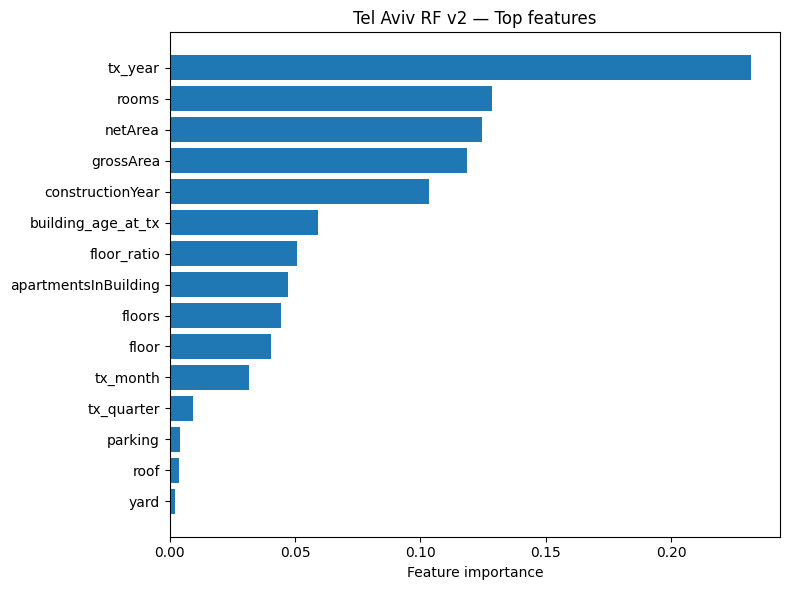

In [32]:
# Cell 7: важность признаков для финальной модели RandomForest v2

import os
import matplotlib.pyplot as plt

# Достаём сам RandomForest из pipeline
rf_v2 = final_rf_v2.named_steps["model"]

importances = rf_v2.feature_importances_

fi_df = (
    pd.DataFrame({
        "feature": feature_cols,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print("Top 10 features by importance:")
display(fi_df.head(10))

# --- Бар-чарт для README ---
plt.figure(figsize=(8, 6))
top_k = 15
plt.barh(
    fi_df["feature"].head(top_k)[::-1],
    fi_df["importance"].head(top_k)[::-1],
)
plt.xlabel("Feature importance")
plt.title("Tel Aviv RF v2 — Top features")
plt.tight_layout()

# сохраняем картинку в папку pics для README
os.makedirs("pics", exist_ok=True)
plt.savefig("pics/tel_aviv_v2_feature_importance.png", dpi=180, bbox_inches="tight")

plt.show()
